# Plots for Needle in Haystack Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import logging
import pickle
from datetime import datetime
import os

#### Experiment Details

In [2]:
valA = "ident"
valC = "_ident_C"
state_dim = 5
ckpt_step = 15600
experiment = "250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
num_examples = 200
nope = False

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
errs_loc = errs_dir + f"/needle_{datasource}_" + f"{valA}_state_dim_{state_dim}_"
seg_ext_errs_loc = errs_dir + f"/needle_{datasource}_fin_seg_ext_" + f"{valA}_state_dim_{state_dim}_"


quartiles_file = model_dir + experiment + "/needles/quartiles.npz"

seg_ext_quartiles_file = model_dir + experiment + "needles/seg_ext_quartiles.npz"

if os.path.exists(quartiles_file):
    print(f"Loading quartiles from {quartiles_file}")
    quartiles = np.load(quartiles_file)

if os.path.exists(seg_ext_quartiles_file):
    print(f"Loading quartiles from {seg_ext_quartiles_file}")
    seg_ext_quartiles = np.load(seg_ext_quartiles_file)


print(f"Loading errors from {errs_loc}")

Loading errors from ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=15600.ckpt/needle_val_ident_state_dim_5_


#### load the err_lss_examples at path which is numpy array

In [3]:
with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
    err_lss_examples = pickle.load(f)

with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
    seg_ext_err_lss_examples = pickle.load(f)

In [4]:
for key in err_lss_examples.keys():
    print(f"shape of examples[{key}]: {err_lss_examples[key].shape}")

for key in seg_ext_err_lss_examples.keys():
    print(f"shape of seg_ext_examples[{key}]: {seg_ext_err_lss_examples[key].shape}")

shape of examples[MOP]: (200, 19, 2000, 251)
shape of examples[Zero]: (200, 19, 2000, 251)
shape of seg_ext_examples[MOP]: (200, 1, 2000, 251)
shape of seg_ext_examples[Zero]: (200, 1, 2000, 251)


#### Compute the Quartiles

In [5]:
def comp_quartiles(err_lss_examples, ratio=False):
    quartiles = {}
    kal_err = None
    if ratio:
        kal_err = err_lss_examples["Kalman_rem"]
    

    for key in err_lss_examples.keys():
        if not (key == "Analytical_Kalman" or key == "Kalman_rem" or key == "Kalman"):
            if ratio:
                rat = err_lss_examples[key] / kal_err
            else:
                rat = err_lss_examples[key]
            med = np.median(rat, axis=2)
            print(f"shape of med: {med.shape}")
            quartiles[key] = np.percentile(med, [25,50,75], axis=0)
            print(f"shape of quartiles[{key}]: {quartiles[key].shape}")
            
    return quartiles


In [15]:
if valA == "gaussA":
    rat = True
else:
    rat = False
quartiles = comp_quartiles(err_lss_examples, ratio=rat)

#save quartiles to npz file
np.savez(quartiles_file, **quartiles)

shape of med: (200, 19, 251)
shape of quartiles[MOP]: (3, 19, 251)


/home/sultand/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


shape of med: (200, 19, 251)
shape of quartiles[Zero]: (3, 19, 251)


In [16]:
seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)

#save seg_ext_quartiles to npz file
np.savez(seg_ext_quartiles_file, **seg_ext_quartiles)

shape of med: (200, 1, 251)
shape of quartiles[MOP]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[Zero]: (3, 1, 251)


## Plotting Code

### final trace

In [ ]:
#load quartiles from npz file
quartiles = np.load(quartiles_file)

In [9]:
haystack_len = quartiles["MOP"].shape[1]

print(f"quartiles[mop] shape: {quartiles['MOP'].shape}, seg_ext_quartiles[mop] shape: {seg_ext_quartiles['MOP'].shape}")

print(f"haystack_len: {haystack_len}")

quartiles[mop] shape: (3, 19, 251), seg_ext_quartiles[mop] shape: (3, 1, 251)
haystack_len: 19


real_steps: [230, 231, 232, 234, 239], real_steps_ext: [228, 229, 230, 232, 237]
key_count: 0
needle: 0, step: 1, real_step: 230
y: 0.00829427782446146
needle: 0, step: 2, real_step: 231
y: 0.00015076719864737242
needle: 0, step: 3, real_step: 232
y: 0.0001160626343335025
needle: 0, step: 5, real_step: 234
y: 8.718022945686243e-05
needle: 0, step: 10, real_step: 239
y: 9.685301120043732e-05
key_count: 1
needle: 0, step: 1, real_step: 230
y: 0.8734456300735474
needle: 0, step: 2, real_step: 231
y: 0.8734456300735474
needle: 0, step: 3, real_step: 232
y: 0.8734456300735474
needle: 0, step: 5, real_step: 234
y: 0.8734456300735474
needle: 0, step: 10, real_step: 239
y: 0.8734456300735474
key_count: 0
needle: 1, step: 1, real_step: 230
y: 0.010438463650643826
needle: 1, step: 2, real_step: 231
y: 0.0001515946933068335
needle: 1, step: 3, real_step: 232
y: 0.00011644323603832163
needle: 1, step: 5, real_step: 234
y: 8.797900227364153e-05
needle: 1, step: 10, real_step: 239
y: 9.8281481768935

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


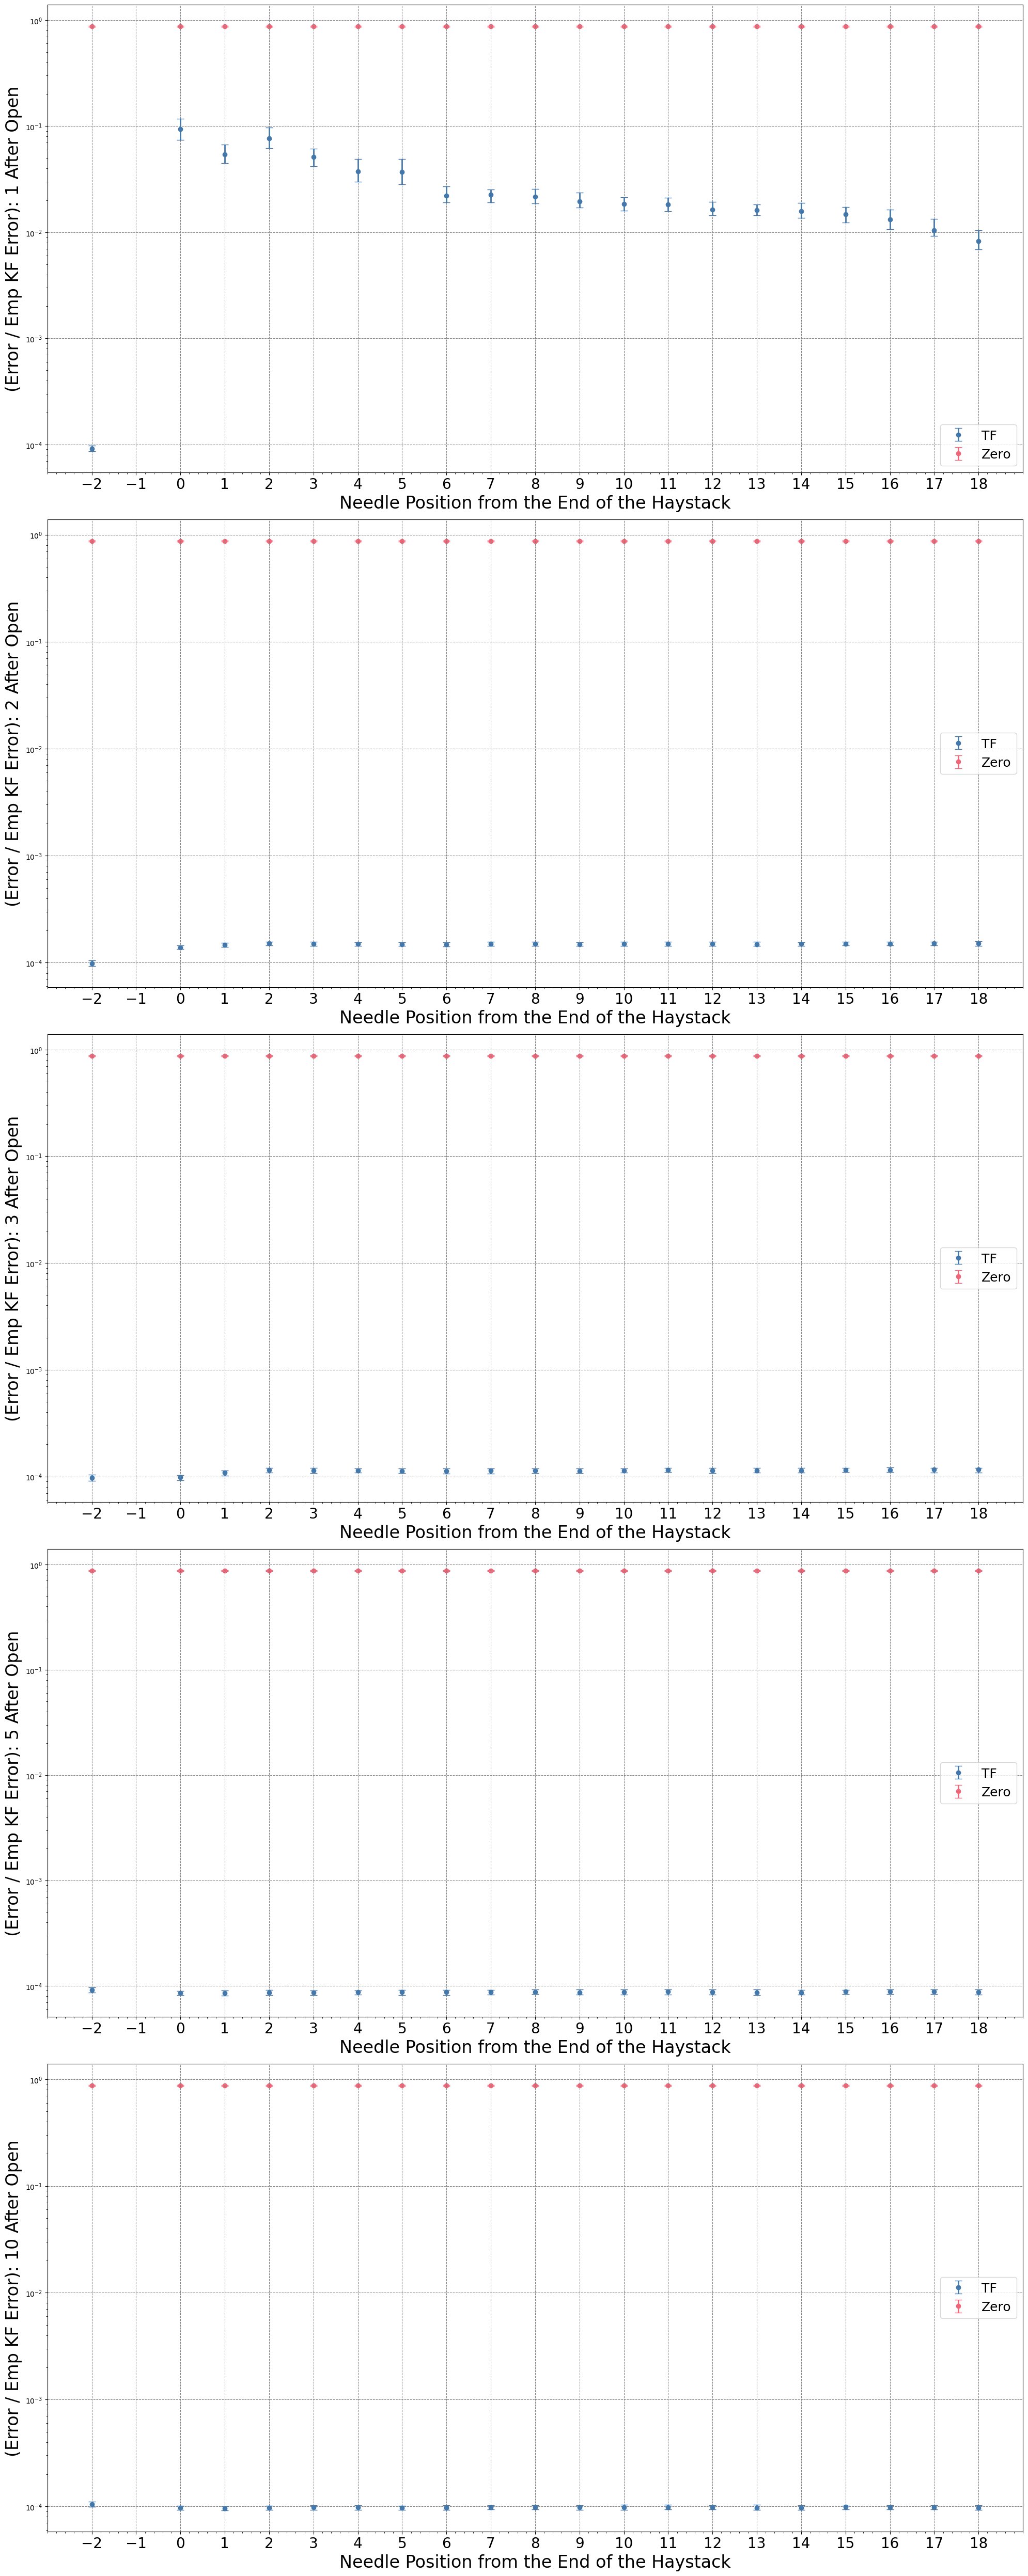

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


In [13]:
steps_in = [1,2,3,5,10]
open_paren_ind = 229
real_steps = [x + open_paren_ind for x in steps_in]
real_steps_ext = [x + open_paren_ind-2 for x in steps_in]

fig, ax = plt.subplots(len(steps_in), 1, sharex=True, figsize=(20, 10*len(steps_in)))

#get a high contrast color map
colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44", "#66CCEE"]

print(f"real_steps: {real_steps}, real_steps_ext: {real_steps_ext}")


for needle in range(haystack_len):
    key_count = 0
    for key in quartiles.keys():
        print(f"key_count: {key_count}")
        if "OLS_analytical" not in key and "Simulation" not in key:
            # ax[needle].scatter(quartiles[key][1, needle], label=key)
            step_count = 0
            for step in steps_in:

                key_label = "TF" if key == "MOP" else key

                print(f"needle: {needle}, step: {step}, real_step: {real_steps[step_count]}")

                y = quartiles[key][1, needle, real_steps[step_count]]
                print(f"y: {y}")
                if valA == "gaussA":
                    y -= 1
                yerr = [
                    quartiles[key][1, needle, real_steps[step_count]] - quartiles[key][0, needle, real_steps[step_count]],
                    quartiles[key][2, needle, real_steps[step_count]] - quartiles[key][1, needle, real_steps[step_count]]
                ]#

                yerr = np.array([[yerr[0]], [yerr[1]]])

                ax[step_count].errorbar(
                    haystack_len - needle - 1,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label=f"{key_label}" if needle == 0 else "_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color=colors[key_count],
                    linewidth=2
                )

                step_count += 1
            key_count += 1

key_count = 0
for key in seg_ext_quartiles.keys():
    if "OLS_analytical" not in key and "Simulation" not in key:
        step_count = 0
        for step in steps_in:
            y = seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            if valA == "gaussA":
                y -= 1
            yerr = [
                seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][0, 0, real_steps_ext[step_count]],
                seg_ext_quartiles[key][2, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            ]

            yerr = np.array([[yerr[0]], [yerr[1]]])
            
            ax[step_count].errorbar(
                -2,
                y,
                yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                fmt='o',
                label="_nolegend_",
                capsize=5,
                zorder=haystack_len if key == "MOP" else 0, color = colors[key_count], 
                linewidth=2
            )

            ax[step_count].legend(fontsize = 18)
            ax[step_count].set_xlabel("Needle Position from the End of the Haystack", fontsize=24, fontname="Times New Roman")
            ax[step_count].set_ylabel(f"(Error / Emp KF Error): {step} After Open", fontsize=24)
            ax[step_count].set_xlim(-3, haystack_len)
            ax[step_count].grid(True)
            ax[step_count].minorticks_on()
            ax[step_count].grid(which='major', linestyle='--', linewidth='0.75', color='gray')
            # ax[step_count].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
            #set the grid to be on integer values for x-axis
            ax[step_count].set_xticks(np.arange(-2, haystack_len, 1))
            ax[step_count].set_yscale('log')
            # ax[step_count].set_ylim(0.3, 3)
            ax[step_count].tick_params(axis='x', which='both', labelbottom=True, labelsize=20)

            step_count += 1
        key_count += 1


fig.tight_layout()

plt.show()

os.makedirs(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}", exist_ok=True)
fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}/error_ratios_{valA}_state_dim_{state_dim}{valC}_step_{ckpt_step}.pdf", transparent=True)



In [43]:
#make a figure with haystack_len subplots
fig, ax = plt.subplots(haystack_len, 1, sharex=True, figsize=(40, 250))
print(f"haystack_len: {haystack_len}")
for needle in range(haystack_len):
    for key in quartiles.keys():
        if "OLS_analytical" not in key:
            # ax[needle].scatter(quartiles[key][1, needle], label=key)
            ax[needle].errorbar(np.arange(quartiles[key].shape[-1]), quartiles[key][1, needle], yerr=[quartiles[key][1, needle] - quartiles[key][0, needle], quartiles[key][2, needle] - quartiles[key][1, needle],], fmt='o', label=f"{key}", capsize=2, zorder=haystack_len if key == "MOP" else 0)
    ax[needle].legend()
    ax[needle].grid(which="both")
    ax[needle].set_xlim(left=0, right=quartiles[key].shape[-1])  # set the x axis limits haystack_len*12 + 2
    # ax[needle].set_ylim(bottom=0, top=5.5)  # set the y axis limits

    # Optionally, customize major and minor ticks
    ax[needle].minorticks_on()

    # Set minor vertical grid lines to be on intervals of 1
    # Set major ticks on every interval of 50
    ax[needle].set_xticks(range(int(ax[needle].get_xlim()[0]), int(ax[needle].get_xlim()[1]) + 1, 5))

    # Set minor vertical grid lines to be on intervals of 1
    ax[needle].set_xticks(range(int(ax[needle].get_xlim()[0]), int(ax[needle].get_xlim()[1]) + 1, 1), minor=True)

    ax[needle].tick_params(axis='both', which='major', length=7, width=1, labelsize=20)
    ax[needle].tick_params(axis='both', which='minor', length=4, width=0.5, labelsize=0)
    ax[needle].grid(which='major', linestyle='-', linewidth=1)
    ax[needle].grid(which='minor', linestyle='--', linewidth=0.5)
    ax[needle].set_ylabel("Median Prediction Error", fontsize=20)
    ax[needle].set_xlabel("Context", fontsize=20)
    ax[needle].set_title(f"Prediction Error for Needle Position {needle}", fontsize=30)

#add the date and time to the filename
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

#add a caption to the bottom of the figure
fig.text(0.5, 0.1, f"Median of {num_examples} haystack configuration examples. step=" + str(ckpt_step) + "_" + timestamp, ha='center', fontsize=30)

haystack_len: 1


Text(0.5, 0.1, 'Median of 200 haystack configuration examples. step=141000_20250123_210121')